In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from keras.models import Model

In [3]:
sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=20)

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
df = pd.read_csv('sf_dataset.csv', parse_dates=['date'], index_col=['date', 'time'])
df = df.pop('Power')

In [128]:
train_df = df[df.index.get_level_values('date') < '2023-02-01']
test_df = df[df.index.get_level_values('date') >= '2023-02-01']

train_df = train_df.values.reshape(-1, 1)
test_df = test_df.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
train_df_sc = scaler.fit_transform(train_df)
test_df_sc = scaler.transform(test_df)

# train_df_sc = scaler.transform(train_df)

# train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
# test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [129]:
# print(train_df_sc)

In [130]:
def prepare_data(sequence, n_steps):
    X, y = [], []
    for i in range(0, len(sequence), 24):
        end_ix = i + n_steps
        if end_ix+24 > len(sequence) - 1:
            break
        X.append(sequence[i:end_ix])
        y.append(sequence[end_ix:end_ix+24])
    return np.array(X), np.array(y)

In [131]:
window_size = 30*24
X_train, y_train = prepare_data(train_df_sc, window_size)
X_test, y_test = prepare_data(test_df_sc, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [132]:
print(np.shape(y_test))

(107, 24, 1)


In [133]:
# plt.figure(figsize=(3,3))
# for i in range(1):
#     plt.plot(y_test[i,:])
# plt.show()

In [134]:
# print(np.shape(X_test))

In [135]:
# plt.figure(figsize=(3,3))
# for i in range(5):
#     plt.plot(X_test[i,:])
# plt.show()

In [136]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [137]:
def build_model(T, D):
    inputs = Input(shape=(T, D))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    x = Attention(50)(x)
    x = Dense(120)(x)
    x = Dense(60)(x)
    x = Dense(120)(x)
    x = Dense(60)(x)
    x = Dense(24)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [138]:
 # def build_model(T, D):   
 #    encoder_inputs = Input(shape=(T, D))
 #    encoder_lstm = Bidirectional(LSTM(30, return_sequences=True))
 #    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
 #    state_h = Concatenate()([forward_h, backward_h])
 #    state_c = Concatenate()([forward_c, backward_c])
 #    
 #    # The encoder's full output sequence will be used as the attention's input
 #    attention_input = encoder_outputs
 #    
 #    # Decoder
 #    decoder_inputs = Input(shape=(None, D))
 #    decoder_lstm = LSTM(30, return_sequences=True, return_state=True)
 #    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
 #    
 #    # Attention
 #    attention_layer = Attention(30)
 #    context_vector = attention_layer(attention_input)
 #    
 #    # Combining the context vector with the decoder's outputs for each time step
 #    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])
 #    
 #    # Output layer
 #    output_dense = TimeDistributed(Dense(D))
 #    decoder_outputs = output_dense(decoder_combined_context)
 #    
 #    # Define the model that will turn encoder_inputs and decoder_inputs into decoder_outputs
 #    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 #    return model
 
 # class Attention2(tf.keras.layers.Layer):
 #    def __init__(self, units, activation='tanh', return_attention=False):
 #        super(Attention2, self).__init__()
 #        self.W = tf.keras.layers.Dense(units, activation=activation, use_bias=False,
 #                                       kernel_regularizer=tf.keras.regularizers.l2(1e-5))
 #        self.V = tf.keras.layers.Dense(1, use_bias=False)
 #        self.return_attention = return_attention
 # 
 #    def call(self, inputs, mask=None):
 #        # score shape == (batch_size, max_length, units)
 #        score = self.W(inputs)
 # 
 #        # attention_weights shape == (batch_size, max_length, 1)
 #        attention_weights = self.V(score)
 #        attention_weights = tf.nn.softmax(attention_weights, axis=1)
 # 
 #        if mask is not None:
 #            attention_weights *= tf.cast(mask, dtype=attention_weights.dtype)
 # 
 #        # context_vector shape after sum == (batch_size, hidden_size)
 #        context_vector = tf.matmul(inputs, attention_weights, transpose_a=True)
 #        context_vector = tf.squeeze(context_vector, -1)
 # 
 #        if self.return_attention:
 #            return [context_vector, attention_weights]
 #        else:
 #            return context_vector

In [139]:
from keras.optimizers import Adam
model = build_model(window_size, 1)
epochs = 200
learning_rate = 0.001
# decay_rate = learning_rate / epochs  
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss="mse")
# model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)

Epoch 1/200
10/10 [==============================] - 9s 372ms/step - loss: 0.0480 - val_loss: 0.0159
Epoch 2/200
10/10 [==============================] - 3s 276ms/step - loss: 0.0206 - val_loss: 0.0086
Epoch 3/200
10/10 [==============================] - 3s 258ms/step - loss: 0.0186 - val_loss: 0.0033
Epoch 4/200
10/10 [==============================] - 3s 255ms/step - loss: 0.0175 - val_loss: 0.0025
Epoch 5/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0178 - val_loss: 0.0030
Epoch 6/200
10/10 [==============================] - 3s 271ms/step - loss: 0.0171 - val_loss: 0.0031
Epoch 7/200
10/10 [==============================] - 3s 267ms/step - loss: 0.0174 - val_loss: 0.0029
Epoch 8/200
10/10 [==============================] - 3s 276ms/step - loss: 0.0172 - val_loss: 0.0071
Epoch 9/200
10/10 [==============================] - 3s 270ms/step - loss: 0.0171 - val_loss: 0.0043
Epoch 10/200
10/10 [==============================] - 3s 269ms/step - loss: 0.0167 - val_lo

In [140]:
y_pred = model.predict(X_test)
y_test = np.squeeze(y_test)

4/4 [==============================] - 2s 94ms/step


In [141]:
def mean_absolute_percentage(y_true, y_pred):
    ymean = np.mean(y_true)
    ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]
    mape = (sum(ape) / len(y_true)) * 100
    mape = mape / ymean
    return mape

In [142]:
print('test performance:')
print('\tnRmse:', mean_squared_error(y_test, y_pred, squared=False) / np.max(y_test))
print('\tMAPE:', np.mean(mean_absolute_percentage(y_test, y_pred)))
print('\tnMAE:', mean_absolute_error(y_pred, y_test)/ np.max(y_test))
r2score = []    
for i in range(np.shape(y_pred)[0]):
     r2score.append(r2_score(y_pred[i,:], y_test[i,:]))
print('\tR2:', np.mean(r2score))

test performance:
	nRmse: 0.09262092956334768
	MAPE: 39.058063773238366
	nMAE: 0.0762274077209355
	R2: 0.6686336859232824


In [143]:
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

In [144]:
# print(y_pred[1,:])
# print(y_test[1,:])

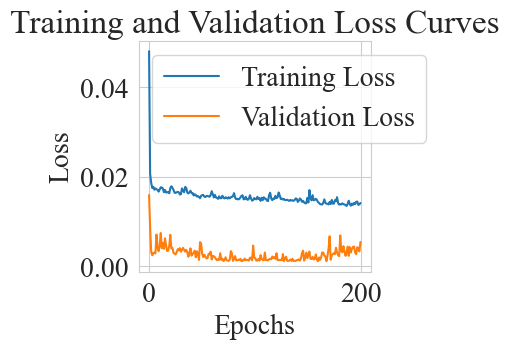

In [145]:
plt.figure(figsize=(3, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

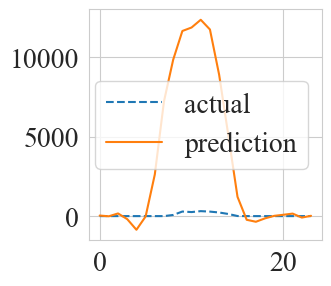

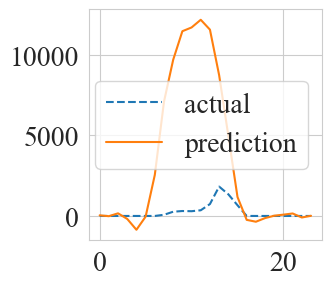

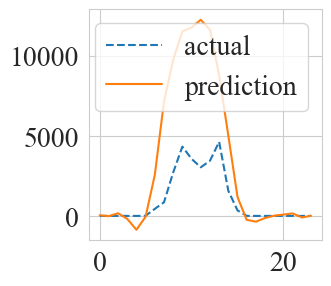

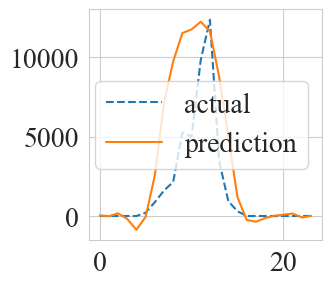

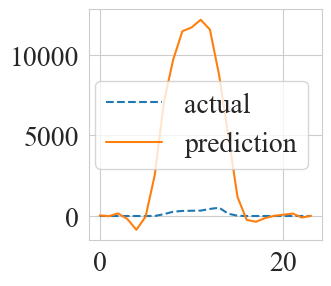

In [146]:
for i in range(5):
    plt.figure(figsize=(3,3))
    plt.plot(y_test[i,:], '--', label='actual')
    plt.plot(y_pred[i,:], label='prediction')
    plt.legend()
    plt.show()

In [5]:
df = pd.read_csv('sf_dataset.csv', parse_dates=['date'], index_col=['date', 'time'])
test_df2 = df[df.index.get_level_values('date') >= '2023-02-01']
selected_columns = test_df2[['Power', 'pvsim']]

In [152]:
# y_test = np.squeeze(y_test)
indices = np.nonzero(selected_columns.Power)[0]
act_nz = selected_columns.Power[indices]
pvsim_nz = selected_columns.pvsim[indices]


print('test performance:')
print('\tnRmse:', mean_squared_error(selected_columns.Power, selected_columns.pvsim, squared=False) / np.max(selected_columns.Power))
print('\tMAPE:', np.mean(mean_absolute_percentage(selected_columns.Power, selected_columns.pvsim)))
print('\tnMAE:', mean_absolute_error(selected_columns.Power, selected_columns.pvsim)/ np.max(selected_columns.Power))
print('\tR2:', r2_score(selected_columns.Power, selected_columns.pvsim))

print('test performance:')
print('\tnRmse:', mean_squared_error(act_nz, pvsim_nz, squared=False) / np.max(act_nz))
print('\tMAPE:', np.mean(mean_absolute_percentage(act_nz, pvsim_nz)))
print('\tnMAE:', mean_absolute_error(act_nz, pvsim_nz)/ np.max(act_nz))
print('\tR2:', r2_score(act_nz, pvsim_nz))

test performance:
	nRmse: 0.08995832662450841
	MAPE: 28.498037489308487
	nMAE: 0.046237506392853275
	R2: 0.8711680017710494
test performance:
	nRmse: 0.1196274933133842
	MAPE: 28.014964933219755
	nMAE: 0.08253440566048967
	R2: 0.8093509403494707


C:\Users\Hossein\AppData\Local\Temp\ipykernel_11316\3843870448.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  act_nz = selected_columns.Power[indices]
C:\Users\Hossein\AppData\Local\Temp\ipykernel_11316\3843870448.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvsim_nz = selected_columns.pvsim[indices]
C:\Users\Hossein\AppData\Local\Temp\ipykernel_11316\1737368977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ape = [

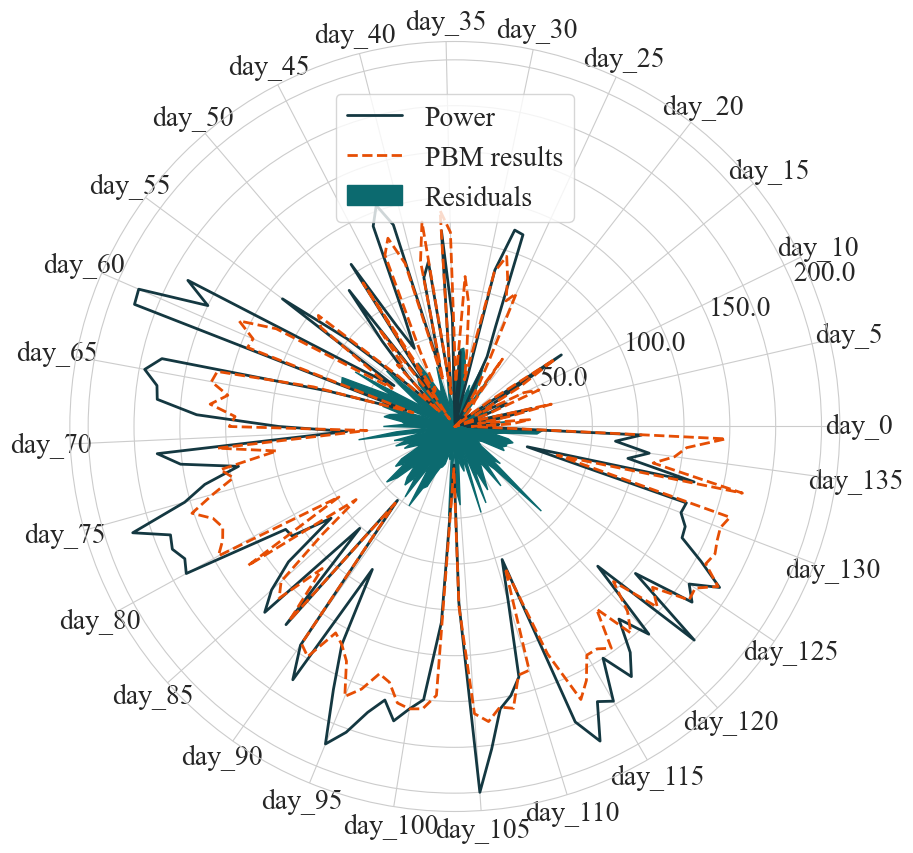

In [25]:
def sum_every_24(values):
    return [sum(values[i:i+24]) for i in range(0, len(values), 24)]
residuals = np.abs(selected_columns.Power-selected_columns.pvsim)
# print(np.shape(residuals))
# Summing every 24 values in 'Power' and 'pvsim'
summed_power = sum_every_24(selected_columns.Power)
summed_pvsim = sum_every_24(selected_columns.pvsim)
summed_residuals = sum_every_24(residuals)
# Prepare the radar plot
num_vars = len(summed_power)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles.append(angles[0])
summed_power.append(summed_power[0])
summed_pvsim.append(summed_pvsim[0])
summed_residuals.append(summed_residuals[0])

summed_power= list(map(lambda x: x//1000, summed_power))
summed_pvsim= list(map(lambda x: x//1000, summed_pvsim))
summed_residuals= list(map(lambda x: x//1000, summed_residuals))
# summed_pvsim= summed_pvsim/1000
# summed_residuals= summed_residuals/1000

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))
# ax.plot(angles,summed_residuals,linewidth=2,color='#E64E04')

ax.plot(angles, summed_power,linewidth=2, label='Power', color='#143841')  # Plot summed 'Power'
# ax.fill(angles, summed_power, alpha=0.25, color='#143841')   # Fill
ax.plot(angles, summed_pvsim,'--' , linewidth=2, label='PBM results',color='#E64E04')  # Plot summed 'pvsim'

# ax.fill(angles, summed_pvsim, alpha=0.25,color='#E64E04')   # Fill
ax.fill(angles, summed_residuals,color='#0C6A6F', label='Residuals')   # Fill

y_ticks = ax.get_yticks()
y_labels = ['' if i%2 else str(y_tick) for i, y_tick in enumerate(y_ticks[1:-1])]
ax.set_yticks(y_ticks[1:-1])
ax.set_yticklabels(y_labels)
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 0.95))
ax.set_xticks(angles[::5])
ax.set_xticklabels([f"day_{i}" for i in range(0, num_vars, 5)]) 
plt.savefig('pvsim_plot_new.png', dpi=500)
plt.show()

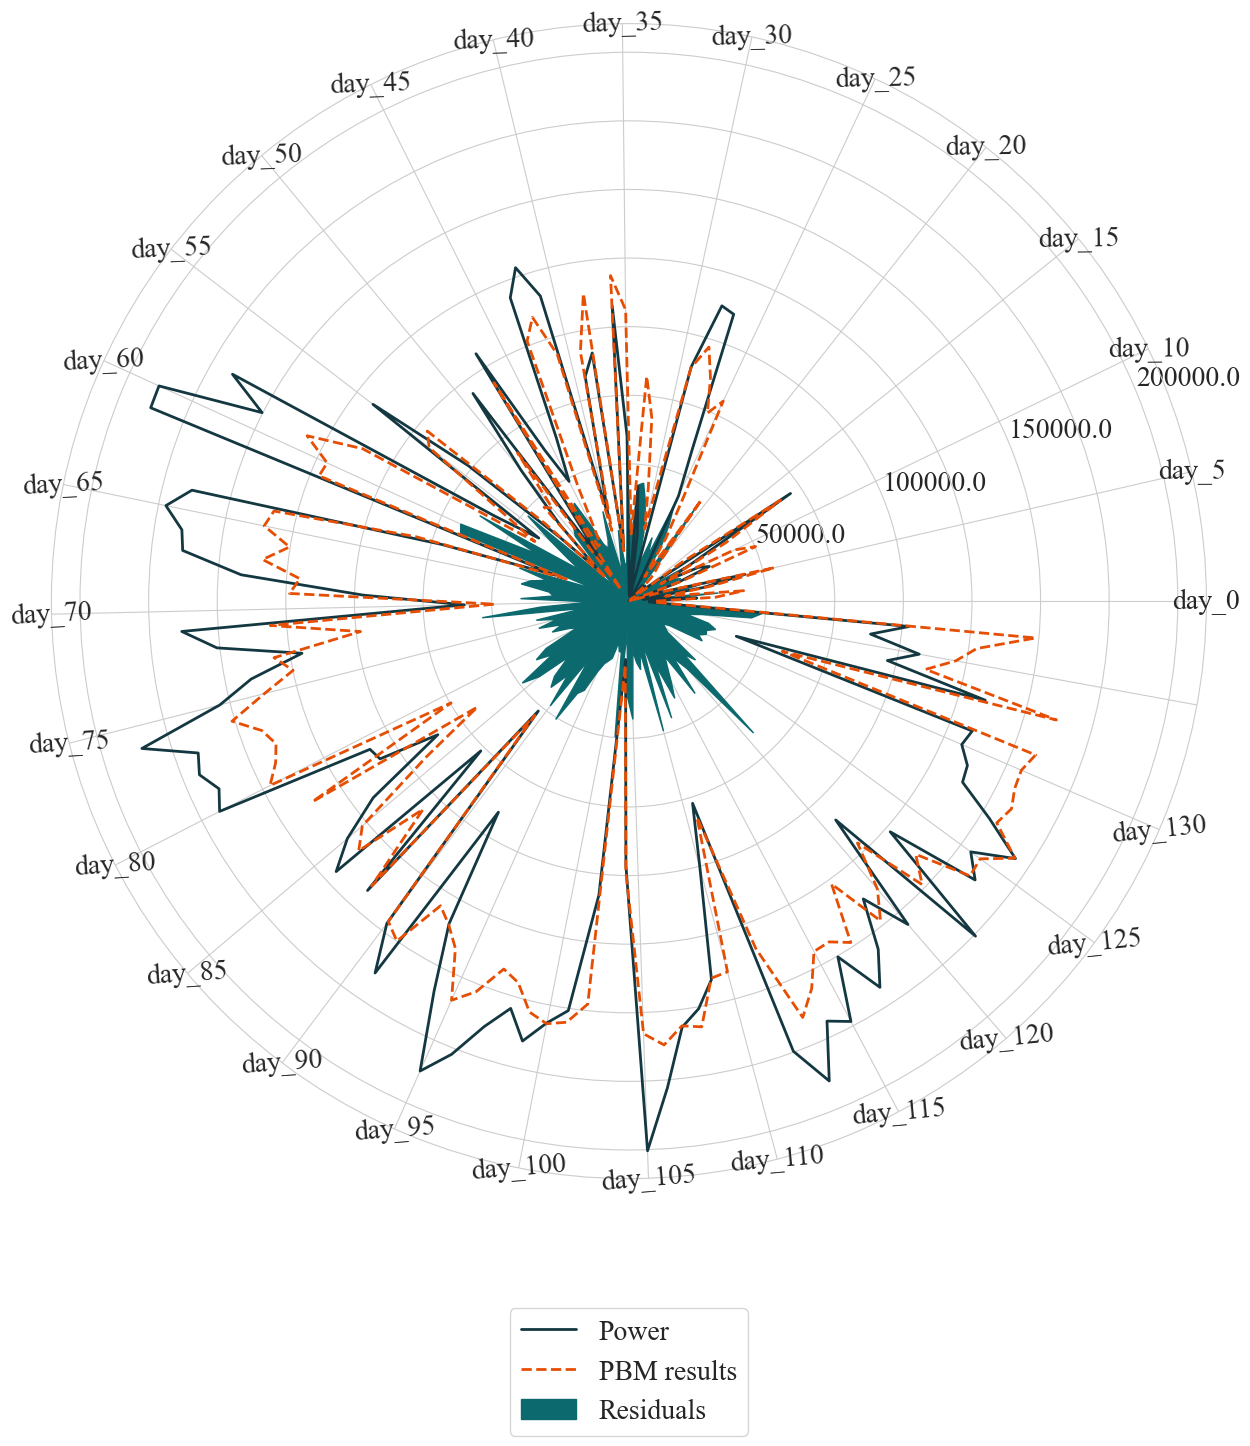

In [19]:
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(polar=True))

ax.plot(angles, summed_power, linewidth=2, label='Power', color='#143841')
ax.plot(angles, summed_pvsim, '--', linewidth=2, label='PBM results', color='#E64E04')
ax.fill(angles, summed_residuals, color='#0C6A6F', label='Residuals')

# Adjust y-ticks
y_ticks = ax.get_yticks()
y_labels = ['' if i % 2 else str(y_tick) for i, y_tick in enumerate(y_ticks[1:-1])]
ax.set_yticks(y_ticks[1:-1])
ax.set_yticklabels(y_labels)

# Set the x-ticks to only include every fifth label
ax.set_xticks(angles[::5])
# To ensure finite values for position, use radial distance and angle
for angle, label in zip(angles[::5], [f"day_{5 * i}" for i in range(0, num_vars // 5)]):
    ax.text(angle, ax.get_rmax() + 10, label, horizontalalignment='center', verticalalignment='center', rotation=angle, rotation_mode='anchor')

# Remove original x-tick labels
ax.set_xticklabels([])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10))

# plt.savefig('/mnt/data/pvsim_plot_new.png', dpi=500)
plt.show()

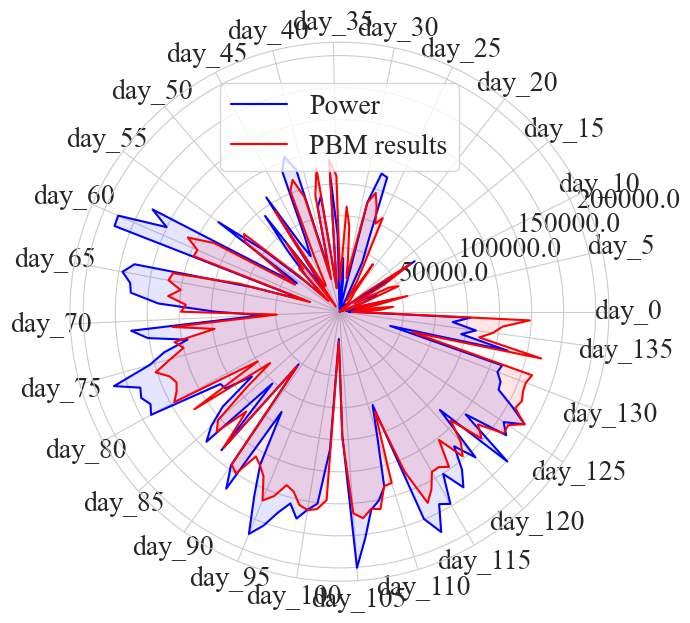

In [7]:
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))
ax.fill(angles, summed_power, 'b', alpha=0.1)  # First fill to the top line
ax.fill(angles, summed_pvsim, 'r', alpha=0.1)  # Second fill to the bottom line
ax.plot(angles, summed_power, label='Power', color='blue')
ax.plot(angles, summed_pvsim, label='PBM results', color='red')
y_ticks = ax.get_yticks()
y_labels = ['' if i%2 else str(y_tick) for i, y_tick in enumerate(y_ticks[1:-1])]
ax.set_yticks(y_ticks[1:-1])
ax.set_yticklabels(y_labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
ax.set_xticks(angles[::5])
ax.set_xticklabels([f"day_{i}" for i in range(0, num_vars, 5)])
# plt.savefig('pvsim_plot.png', dpi=500)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


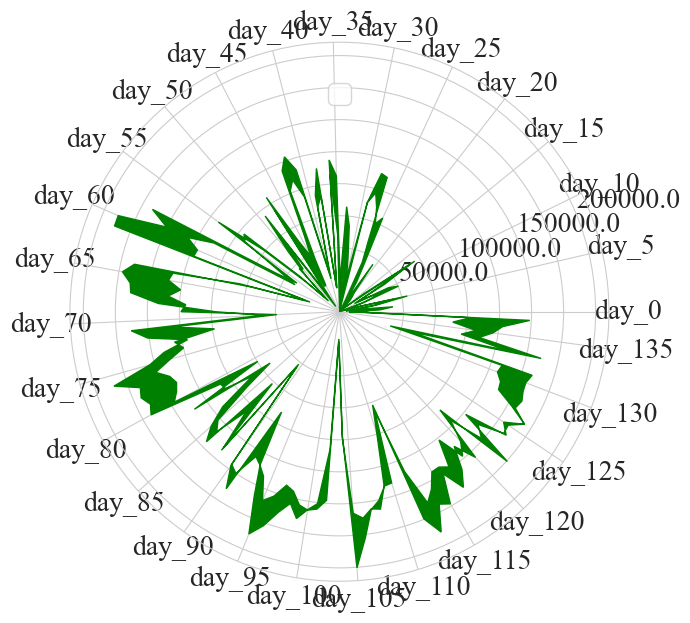

In [8]:
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))
verts = [(angle, power) for angle, power in zip(angles, summed_power)]
verts += [(angle, pvsim) for angle, pvsim in zip(angles[::-1], summed_pvsim[::-1])]
ax.fill(*zip(*verts), color='green')
y_ticks = ax.get_yticks()
y_labels = ['' if i%2 else str(y_tick) for i, y_tick in enumerate(y_ticks[1:-1])]
ax.set_yticks(y_ticks[1:-1])
ax.set_yticklabels(y_labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
ax.set_xticks(angles[::5])
ax.set_xticklabels([f"day_{i}" for i in range(0, num_vars, 5)])
# plt.savefig('pvsim_plot2.png', dpi=500)
plt.show()